# MHBF Project: Reinforcement Learning

Johannes Rieke and Alexander Moore

In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from IPython.core.debugger import Tracer
breakpoint = Tracer()

## Create environment

In [3]:
class Environment():
    
    maze = mpl.path.Path([(5, 0), (5, 50), (55, 50), (55, 60), (-55, 60), (-55, 50), (-5, 50), (-5, 0), (5, 0)])
    pickup_area = mpl.path.Path([(35, 50), (55, 50), (55, 60), (35, 60), (35, 50)])
    target_area = mpl.path.Path([(-55, 50), (-35, 50), (-35, 60), (-55, 60), (-55, 50)])
    
    def __init__(self):
        self.reset()
        
    def _state(self):
        return (self.x, self.y, self.picked_up)
    
    def reset(self):
        self.x = 0
        self.y = 0
        self.picked_up = False
        return self._state()
        
    def step(self, angle):
        distance = np.random.normal(3, 1.5)
        distance = max(0, distance)  # prevent negative distances
        
        dx = distance * np.sin(angle)
        dy = distance * np.cos(angle)
        
        self.x += dx
        self.y += dy
        
        reward = 0
        done = False
        
        if not self.maze.contains_point((self.x, self.y)):
            reward = -1
            start_x = self.x
            start_y = self.y
            
            
            # Move back in small steps.
            for i in range(10):
                
                if abs(self.x) > 100 or abs(self.y) > 100:
                    breakpoint()
                self.x -= 0.1 * distance * np.sin(angle)
                self.y -= 0.1 * distance * np.cos(angle)
                
                if self.maze.contains_point((self.x, self.y)):
                    break
                
        if self.pickup_area.contains_point((self.x, self.y)):
            self.picked_up = True
            
        if self.target_area.contains_point((self.x, self.y)) and self.picked_up:
            reward = 20
            done = True
            
        return self._state(), reward, done
    
    def plot(self):
        plt.gca().add_patch(mpl.patches.PathPatch(env.maze, fc='none'))
        plt.gca().add_patch(mpl.patches.PathPatch(env.pickup_area, fc='blue', ec='none', alpha=0.2))
        plt.gca().add_patch(mpl.patches.PathPatch(env.target_area, fc='red', ec='none', alpha=0.2))
        plt.xlim(-60, 60)
        plt.ylim(-5, 65)
        plt.axis('off')

In [4]:
env = Environment()

In [5]:
def plot_trajectory(xs, ys):
    plt.plot(xs, ys, 'k', alpha=0.4)
    plt.scatter(xs, ys, c=range(len(xs)), cmap='cool', s=10)

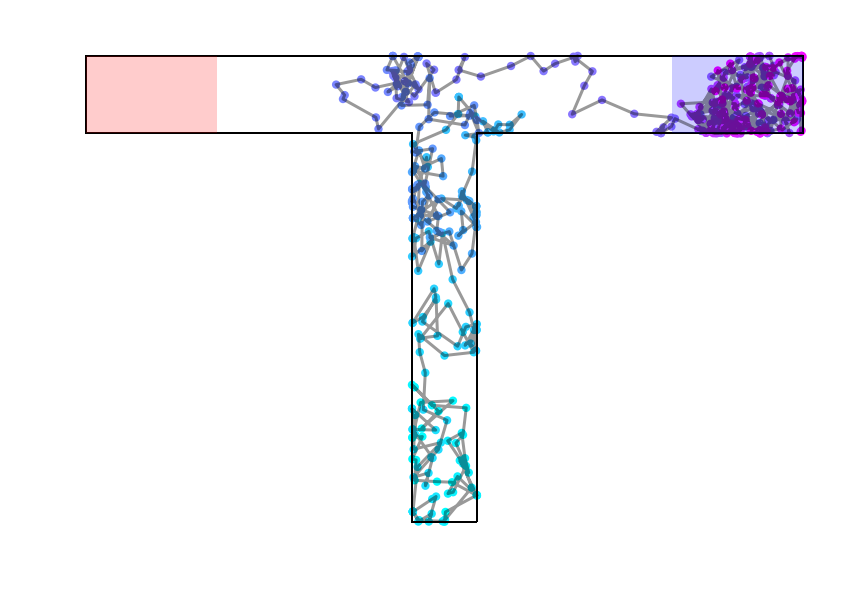

In [6]:
# Random walk in the maze (just to test the visualization).
plt.figure(figsize=(7, 5))

num_steps = 500
xs, ys = np.zeros(num_steps), np.zeros(num_steps)

xs[0], ys[0], _ = env.reset()

for i in range(1, num_steps):
    (xs[i], ys[i], _), reward, done = env.step(np.random.rand() * 2 * np.pi)
    
env.plot()
plot_trajectory(xs, ys)

## Distribute place fields across the environment

In [7]:
# Find coordinates of the place field centers.
place_field_centers = []

# Create an eqully spaced meshgrid across the coordinate system, 
# then filter the points that are inside the maze. 
xx, yy = np.meshgrid(np.arange(-52.5, 53, 5), np.arange(2.5, 60, 5))
for x, y in zip(xx.flatten(), yy.flatten()):
    if env.maze.contains_point((x, y)):
        place_field_centers.append((x, y))

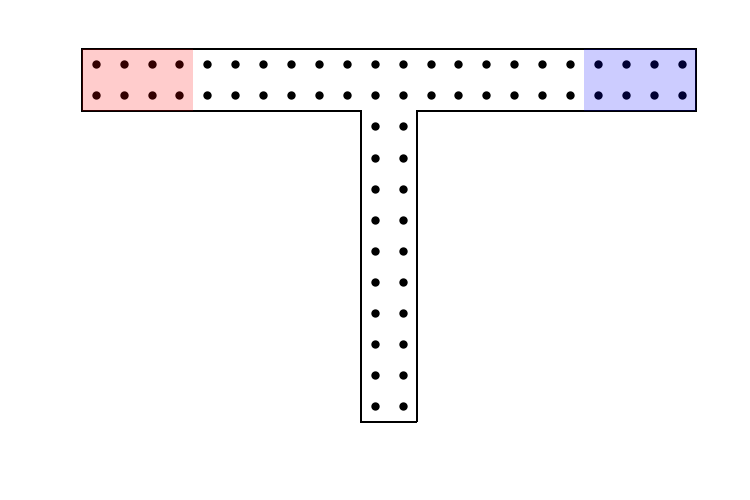

In [8]:
env.plot()
plt.scatter(*np.array(place_field_centers).T, c='k', s=10)

## Calculate activities of the network

In [9]:
class NeuralNetwork():
    
    def __init__(self, place_field_centers, num_actions, sigma=5):
        self.place_field_centers = place_field_centers
        self.sigma = sigma
        self.weights = np.random.rand(num_actions, len(place_field_centers)*2)
        self.eligibility_traces = np.zeros_like(self.weights)
        
    # TODO: Rename input_activation.
    def input_activity(self, state):
        activity_all_neurons = np.zeros(len(self.place_field_centers)*2)
        x, y, picked_up = state

        if picked_up:  # write activations into left half of the neurons
            activity_active_population = activity_all_neurons[len(self.place_field_centers):]  
        else:  # write activation into the right half of the neurons
            activity_active_population = activity_all_neurons[:len(self.place_field_centers)]  

        for i, (x_i, y_i) in enumerate(self.place_field_centers):
            activity_active_population[i] = np.exp(-((x_i - x)**2 + (y_i - y)**2) / (2 * self.sigma**2))

        return activity_all_neurons
    
    # TODO: Rename output_activations.
    def output_activity(self, input_activity):
        return np.dot(self.weights, input_activity)
    
    # TODO: Rename activation.
    def activities(self, state):
        input_activity = self.input_activity(state)
        output_activity = self.output_activity(input_activity)
        return input_activity, output_activity
    
    def update_eligibility_traces(self, input_activity, action, gamma=0.95, decay_rate=0.5):
        self.eligibility_traces *= gamma * decay_rate
        self.eligibility_traces[action] += input_activity
        
    def update_weights(self, reward, Q_sa, Q_sa_next, learning_rate=0.1, gamma=0.95):
        delta = reward + gamma * (Q_sa_next - Q_sa)
        self.weights += learning_rate * delta * self.eligibility_traces

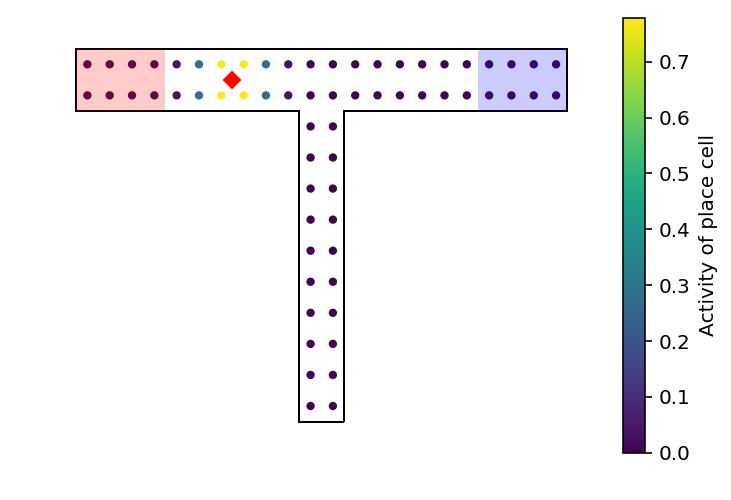

In [10]:
# Visualize activites of the input neurons (place cells).
nn = NeuralNetwork(place_field_centers, 4)
env.plot()

x = -20
y = 55
plt.plot(x, y, 'rD')

activity = nn.input_activity([x, y, False])[:len(place_field_centers)]
plt.scatter(*np.array(place_field_centers).T, c=activity, s=10)
plt.colorbar(label='Activity of place cell')

## Set parameters and train

In [11]:
# Use tqdm package to show a progress bar for the trials.
# To install, uncomment the following line:
# !pip install tqdm
from tqdm import tqdm_notebook

In [12]:
# Context Manager to set numpy print options locally, see https://stackoverflow.com/questions/2891790/how-to-pretty-printing-a-numpy-array-without-scientific-notation-and-with-given
import contextlib

@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    try:
        yield
    finally: 
        np.set_printoptions(**original)

In [13]:
def choose_action(Q_s, epsilon):
    if np.random.rand() < epsilon:  # choose random action
        action = np.random.randint(len(Q_s))
    else:  # choose best action
        action = np.argmax(Q_s)
    return action

In [39]:
def compute_navigation_map_angles(nn, num_actions, picked_up):
    navigation_map_angles = []
    for x, y in place_field_centers:
        _, Q_s = nn.activities([x, y, picked_up])
        best_action = choose_action(Q_s, 0)
        angle = best_action / num_actions * 2 * np.pi
        navigation_map_angles.append(angle)
    return navigation_map_angles

In [40]:
def run_simulations(num_runs=10, num_trials=80, max_steps=10000, num_actions=4, 
                   learning_rate=0.1, gamma=0.95, decay_rate=0.5, 
                   epsilon_start=0.5, epsilon_end=0.05, decay_epsilon_until_trial=60, 
                   verbose=0):
    """
    Run several simulations of the rat learning to navigate in the maze via SARSA.
    
    Arguments:
        num_runs: The number of runs (i.e. rats) to simulate
        num_trials: The number of trials per run
        max_steps: Abort trial after this many steps even if the rat did not reach the target
        num_actions: The number of actions that the rat can take
        learning_rate: The learning rate for SARSA
        gamma: The gamma parameter for SARSA
        decay_rate: The decay_rate of the eligibility trace
        epsilon_start: The value of epsilon at the beginning of a run
        epsilon_end: The value of epsilon at the end of a run
        decay_epsilon_until_trial: Decay epsilon from `epsilon_start` to `epsilon_end` until this trial number
        verbose: 0 for nothing, 1 for trial info, 2 for step info
        
    Returns:
        (num_steps_per_trial_per_run, mean_Q_per_trial_per_run, xs_per_trial, ys_per_trial, navigation_map_angles_not_picked_up_per_trial, navigation_map_angles_picked_up_per_trial)
    """
    
    def verbose1_print(*args, **kwargs):
        if verbose >= 1:
            print(*args, **kwargs)
            
    def verbose2_print(*args, **kwargs):
        if verbose == 2:
            with printoptions(precision=3, suppress=True):
                print(*args, **kwargs)
            

    # Decay epsilon during the first trials and keep it at steady state for the rest of the trials.
    epsilon_per_trial = np.zeros(num_trials)
    epsilon_per_trial[:decay_epsilon_until_trial] = np.linspace(epsilon_start, epsilon_end, decay_epsilon_until_trial)
    epsilon_per_trial[decay_epsilon_until_trial:] = epsilon_end

    
    # Initialize arrays to track results.
    num_steps_per_trial_per_run = []
    mean_Q_per_trial_per_run = []
    # Record these only on first run.
    xs_per_trial = []
    ys_per_trial = []
    navigation_map_angles_picked_up_per_trial = []
    navigation_map_angles_not_picked_up_per_trial = []


    for run in tqdm_notebook(range(1, num_runs+1), desc='Run'):

        # Start run.
        verbose1_print('-'*80)
        verbose1_print('Run', run)
        verbose1_print('-'*80)

        # Create a fresh neural network with random weights.
        nn = NeuralNetwork(place_field_centers, num_actions)

        # Initialize arrays to track results.
        mean_Q_per_trial = []
        num_steps_per_trial = []

        for trial, epsilon in enumerate(tqdm_notebook(epsilon_per_trial, desc='Trial', leave=False), 1):
            
            # Start trial.
            verbose1_print('Trial {} (epsilon={:.3f}):'.format(trial, epsilon), end=' ' if verbose == 1 else '\n')

            # Initialize arrays to track results, compute angles for navigation map.
            Qs = []
            if run == 1:
                xs = []
                ys = []
                navigation_map_angles_not_picked_up_per_trial.append(compute_navigation_map_angles(nn, num_actions, False))
                navigation_map_angles_picked_up_per_trial.append(compute_navigation_map_angles(nn, num_actions, True))

            # Get initial state, calculate Q values and sample action.
            state = env.reset()
            if run == 1:
                xs.append(state[0])
                ys.append(state[1])
            input_activity, Q_s = nn.activities(state)
            action = choose_action(Q_s, epsilon)

            done = False
            step = 0

            # Repeat until mouse has reached the target.
            while not done and step < max_steps:
                step += 1

                verbose2_print('In state: x={:.0f}, y={:.0f}, picked_up={} - Q_s: {} - choosing action: {} (angle: {:.0f})'.format(*state, Q_s, action, action / num_actions * 2 * np.pi))

                # Get next state, calculate Q values and sample next action.
                next_state, reward, done = env.step(action / num_actions * 2 * np.pi)  # TODO: Maybe calculate angle from action directly in Environment.
                next_input_activity, Q_s_next = nn.activities(next_state)
                next_action = choose_action(Q_s_next, epsilon)

                # Perform SARSA update of network weights.
                nn.update_eligibility_traces(input_activity, action, gamma=gamma, decay_rate=decay_rate)
                nn.update_weights(reward, Q_s[action], Q_s_next[next_action], learning_rate=learning_rate, gamma=gamma)

                # Assign variables for next step.
                state, action, input_activity, Q_s = next_state, next_action, next_input_activity, Q_s_next

                if run == 1:
                    xs.append(state[0])
                    ys.append(state[1])
                Qs.append(Q_s)

            num_steps_per_trial.append(step)
            if run == 1:
                xs_per_trial.append(xs)
                ys_per_trial.append(ys)
            mean_Q = np.mean(Qs)
            mean_Q_per_trial.append(mean_Q)
            verbose1_print('Finished in {} steps, mean Q at {:.3f}'.format(step, mean_Q))

        verbose1_print()
        verbose1_print()

        num_steps_per_trial_per_run.append(num_steps_per_trial)
        mean_Q_per_trial_per_run.append(mean_Q_per_trial)
        
    return num_steps_per_trial_per_run, mean_Q_per_trial_per_run, xs_per_trial, ys_per_trial, navigation_map_angles_not_picked_up_per_trial, navigation_map_angles_picked_up_per_trial

In [47]:
num_steps_per_trial_per_run, mean_Q_per_trial_per_run, xs_per_trial, ys_per_trial, navigation_map_angles_not_picked_up_per_trial, navigation_map_angles_picked_up_per_trial = run_simulations(verbose=0)

## Visualize results

### Learning curve

In [108]:
def plot_learning_curve(num_steps_per_trial_per_run, indicate_all=True, indicate_std=False, **plot_kwargs):
    x = range(1, len(num_steps_per_trial_per_run[0])+1)
    
    mean = np.mean(num_steps_per_trial_per_run, axis=0)
    
    # Plot averaged curve.
    line, = plt.plot(x, mean, **plot_kwargs)
    
    if indicate_all:
        # Plot individual curves.
        for num_steps_per_trial in num_steps_per_trial_per_run:
            plt.plot(x, num_steps_per_trial, color=line.get_color(), alpha=0.1, **plot_kwargs)
            
    if indicate_std:
        std = np.std(num_steps_per_trial_per_run, axis=0)
        plt.fill_between(x, mean-std, mean+std, color=line.get_color(), alpha=0.1)
            
    plt.xlabel('Trial')
    plt.ylabel('Number of steps\n(averaged over {} runs)'.format(len(num_steps_per_trial_per_run)))
    plt.ylim(0, 1500)
    
    return line

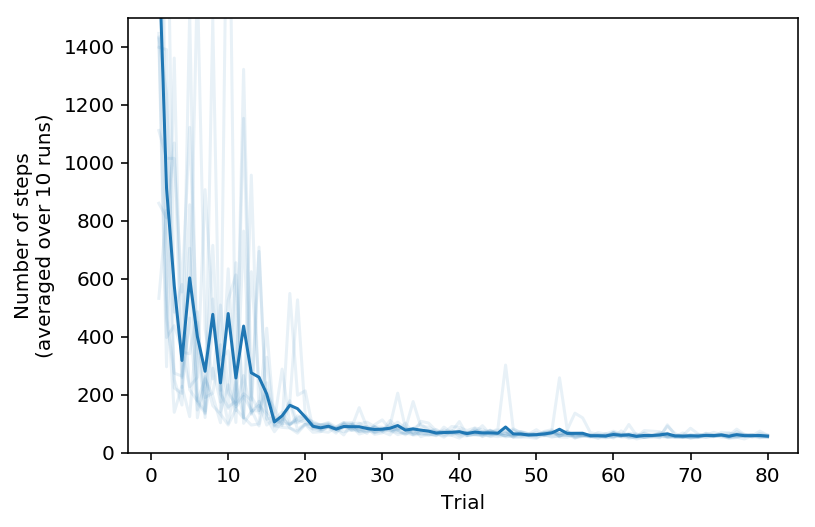

In [111]:
plot_learning_curve(num_steps_per_trial_per_run)

### Mean Q over trials

In [112]:
def plot_mean_Q(mean_Q_per_trial_per_run, indicate_all=True, **plot_kwargs):
    x = range(1, len(mean_Q_per_trial_per_run[0])+1)
    
    # Plot averaged curve.
    line, = plt.plot(x, np.mean(mean_Q_per_trial_per_run, axis=0), **plot_kwargs)
    
    if indicate_all:
        # Plot individual curves.
        for mean_Q_per_trial in mean_Q_per_trial_per_run:
            plt.plot(x, mean_Q_per_trial, color=line.get_color(), alpha=0.1, **plot_kwargs)
    
    plt.xlabel('Trial')
    plt.ylabel('Mean Q value\n(averaged over {} runs)'.format(len(mean_Q_per_trial_per_run)))

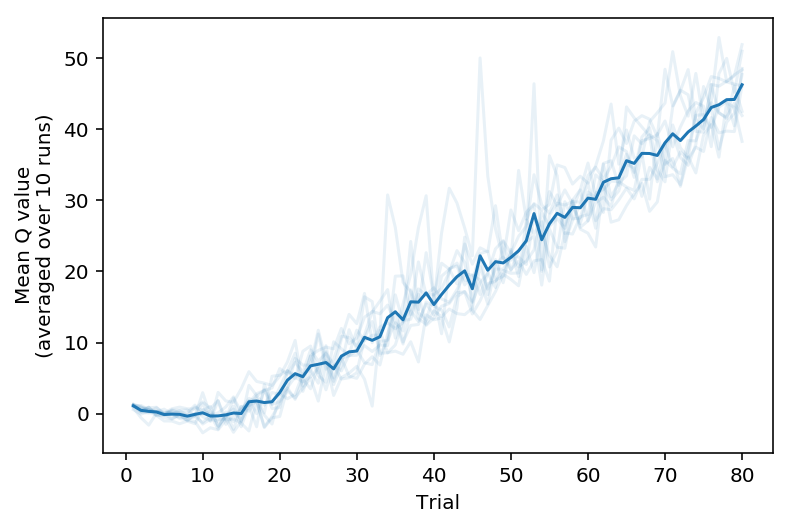

In [113]:
plot_mean_Q(mean_Q_per_trial_per_run)

### Trajectories

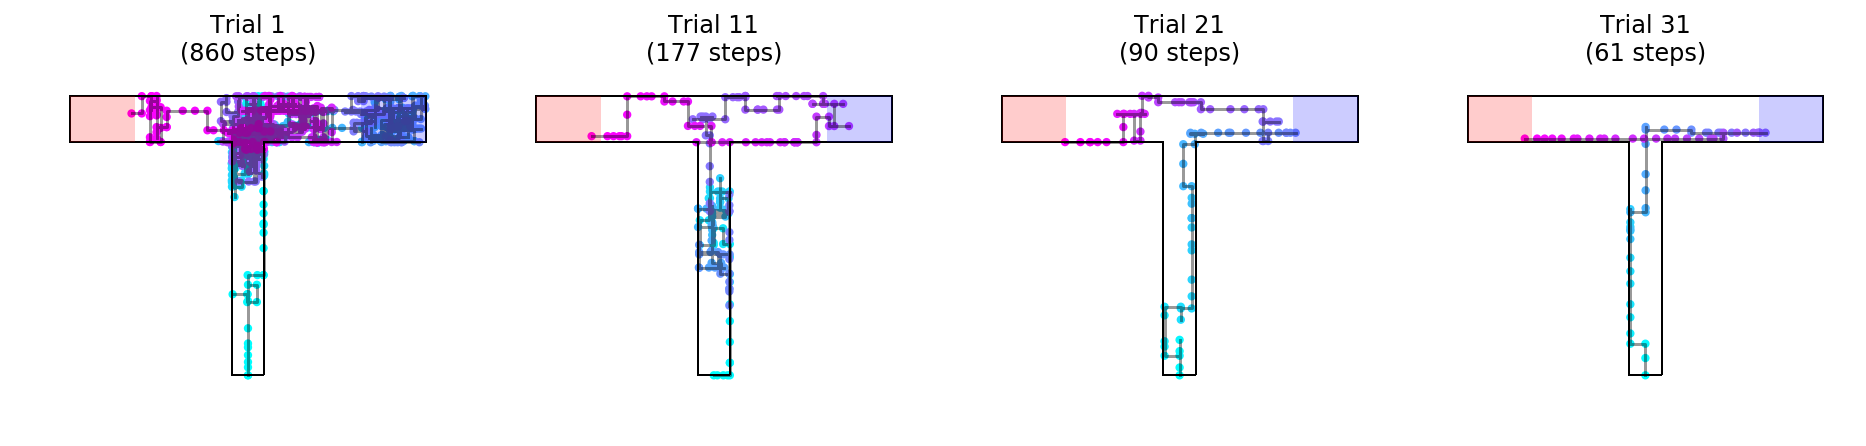

In [72]:
skip_trials = 10

fig, axes = plt.subplots(1, 4, figsize=(16, 3))
for i, ax in enumerate(axes.flatten()):
    plt.sca(ax)
    env.plot()
    trial = i * skip_trials
    plot_trajectory(xs_per_trial[trial], ys_per_trial[trial])
    plt.title('Trial {}\n({} steps)'.format(trial+1, num_steps_per_trial_per_run[0][trial]))

### Navigation maps

In [73]:
arrow_length = 2
head_width = 2
head_length = 1.5
skip_trials = 10

In [74]:
def plot_navigation_map(positions, angles, arrow_length=2, **arrow_kwargs):
    for (x, y), angle in zip(positions, angles):
        #plt.plot(x, y, marker=(3, 0, angle / np.pi * 180), markersize=4, lw=0, mfc='k', mec='k')
        dx = arrow_length * np.sin(angle)
        dy = arrow_length * np.cos(angle)
        plt.arrow(x-dx/2, y-dy/2, dx/2, dy/2, color='k', **arrow_kwargs)

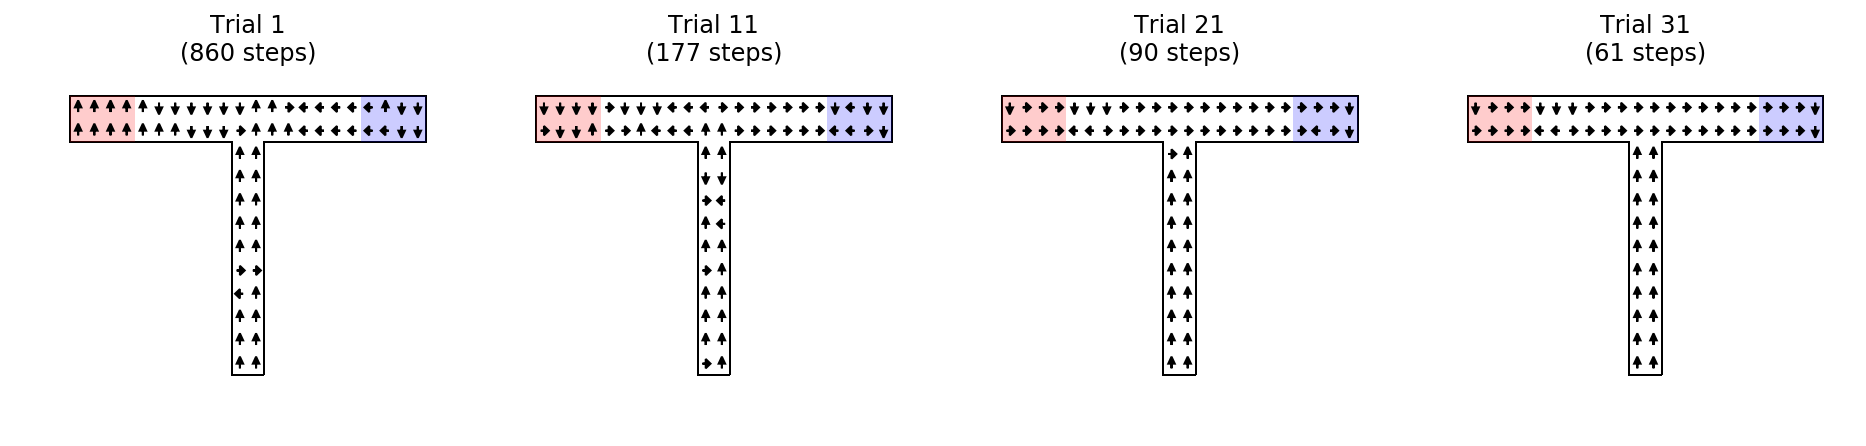

In [75]:
# Before pickup.
fig, axes = plt.subplots(1, 4, figsize=(16, 3))
for i, ax in enumerate(axes.flatten()):
    plt.sca(ax)
    env.plot()
    trial = i * skip_trials
    plt.title('Trial {}\n({} steps)'.format(trial+1, num_steps_per_trial_per_run[0][trial]))
    plot_navigation_map(place_field_centers, navigation_map_angles_not_picked_up_per_trial[trial], arrow_length=arrow_length, head_width=head_width, head_length=head_length)

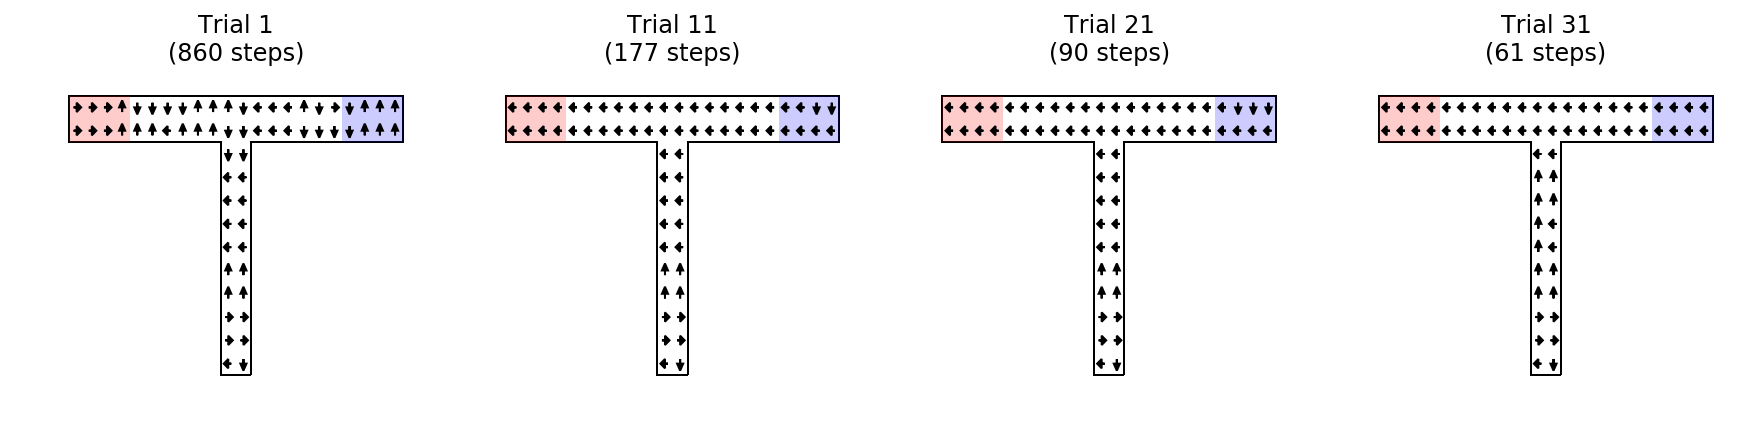

In [76]:
# After pickup.
fig, axes = plt.subplots(1, 4, figsize=(15, 3))
for i, ax in enumerate(axes.flatten()):
    plt.sca(ax)
    env.plot()
    trial = i * skip_trials
    plt.title('Trial {}\n({} steps)'.format(trial+1, num_steps_per_trial_per_run[0][trial]))
    plot_navigation_map(place_field_centers, navigation_map_angles_picked_up_per_trial[trial], arrow_length=arrow_length, head_width=head_width, head_length=head_length)

### Trajectories + navigation maps

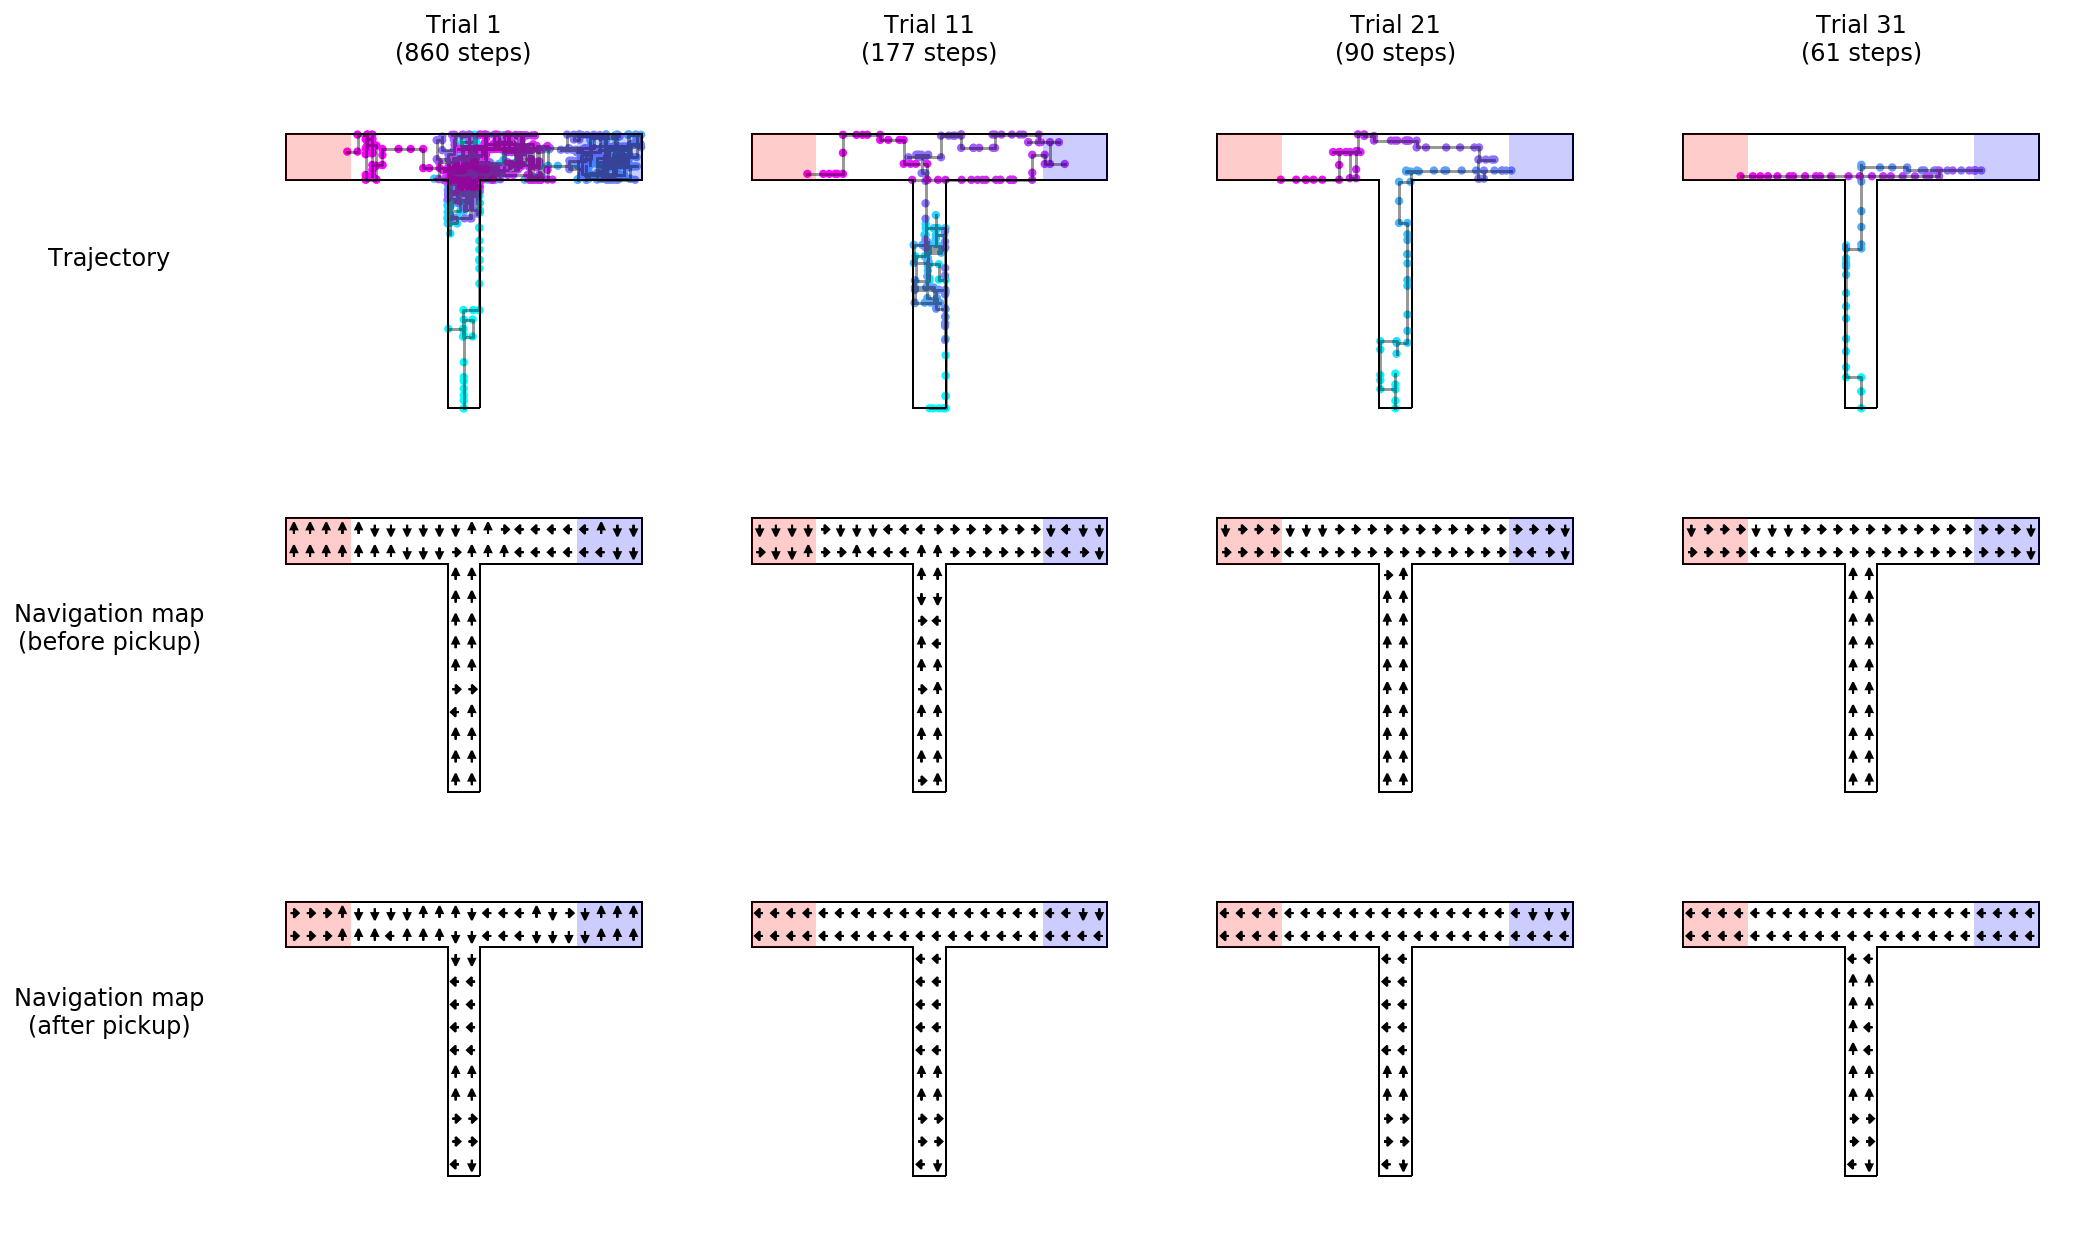

In [77]:
skip_trials = 10

fig, axes = plt.subplots(3, 4, figsize=(16, 10))

def set_row_title(axes_row, title):
    plt.sca(axes_row[0])
    plt.ylabel(title, rotation='horizontal', size='large', labelpad=80)
    plt.axis('on')
    plt.xticks([])
    plt.yticks([])
    plt.box(on=None)

    
# Plot trajectories.
for i, ax in enumerate(axes[0].flatten()):
    plt.sca(ax)
    env.plot()
    trial = i * skip_trials
    plot_trajectory(xs_per_trial[trial], ys_per_trial[trial])
    plt.title('Trial {}\n({} steps)'.format(trial+1, num_steps_per_trial_per_run[0][trial]), y=1.12)
    
set_row_title(axes[0], 'Trajectory')
    
    
# Plot navigation maps before pickup.
for i, ax in enumerate(axes[1].flatten()):
    plt.sca(ax)
    env.plot()
    trial = i * skip_trials
    #plt.title('Trial {}\n({} steps)'.format(trial+1, num_steps_per_trial_per_run[0][trial]))
    plot_navigation_map(place_field_centers, navigation_map_angles_not_picked_up_per_trial[trial], arrow_length=arrow_length, head_width=head_width, head_length=head_length)
    
set_row_title(axes[1], 'Navigation map\n(before pickup)')
    
    
# Plot navigation maps after pickup
for i, ax in enumerate(axes[2].flatten()):
    plt.sca(ax)
    env.plot()
    trial = i * skip_trials
    #plt.title('Trial {}\n({} steps)'.format(trial+1, num_steps_per_trial_per_run[0][trial]))
    plot_navigation_map(place_field_centers, navigation_map_angles_picked_up_per_trial[trial], arrow_length=arrow_length, head_width=head_width, head_length=head_length)
    
set_row_title(axes[2], 'Navigation map\n(after pickup)')

## Explore different parameter settings

### Decay rate

In [120]:
decay_rates = [0, 0.5, 0.9]
results_per_decay_rate = [run_simulations(decay_rate=decay_rate) for decay_rate in decay_rates]

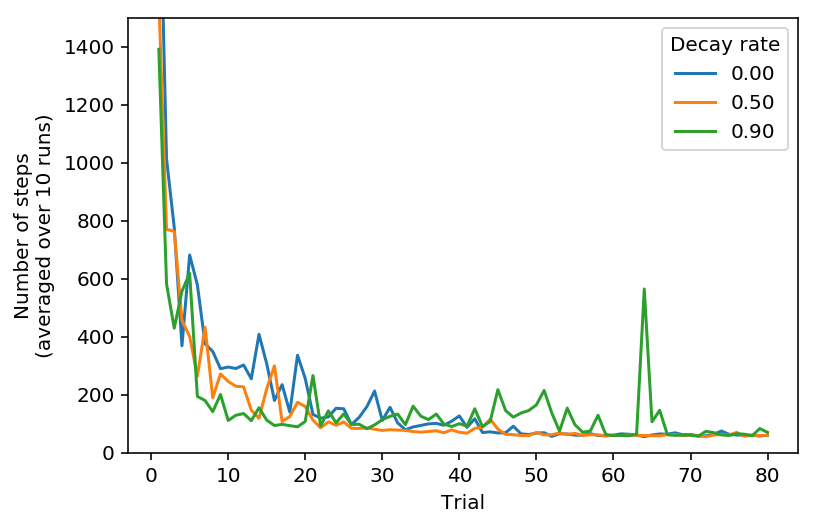

In [121]:
[plot_learning_curve(results[0], indicate_all=False) for results in results_per_decay_rate]
plt.legend(list(map('{:.2f}'.format, decay_rates)), title='Decay rate')
#plt.ylim(0, 5000)

- Medium decay rate gives best results overall
- Small decay rate learns quite slowly
- High decay rate learns faster initially, but does not converge for some runs

### Epsilon

In [116]:
epsilon_starts = [0.9, 0.5, 0.05]
results_per_epsilon_start = [run_simulations(epsilon_start=epsilon_start) for epsilon_start in epsilon_starts]

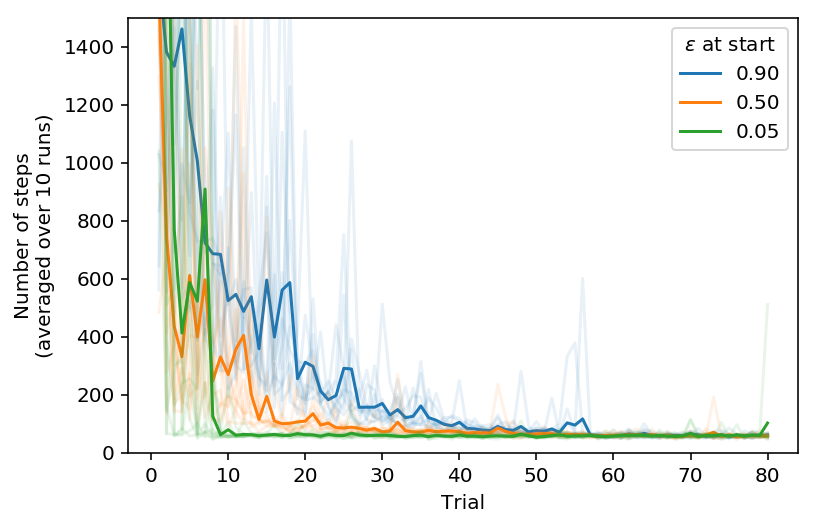

In [117]:
lines = [plot_learning_curve(results[0], indicate_all=True) for results in results_per_epsilon_start]
plt.legend(lines, map('{:.2f}'.format, epsilon_starts), title='$\epsilon$ at start')
#plt.ylim(0, 5000)

- Medium epsilon at start gives best results overall
- High epsilon at start learns very slowly because it spends a lot of time exploring the maze
- Small epsilon seems to learn a bit faster, but if it gets stuck in a place that wasn't explored previously, it can spend a lot of time there (see bumps at large trial number)

### Number of actions

In [118]:
num_actions_list = [4, 10, 30]
results_per_num_actions = [run_simulations(num_actions=num_actions) for num_actions in num_actions_list]

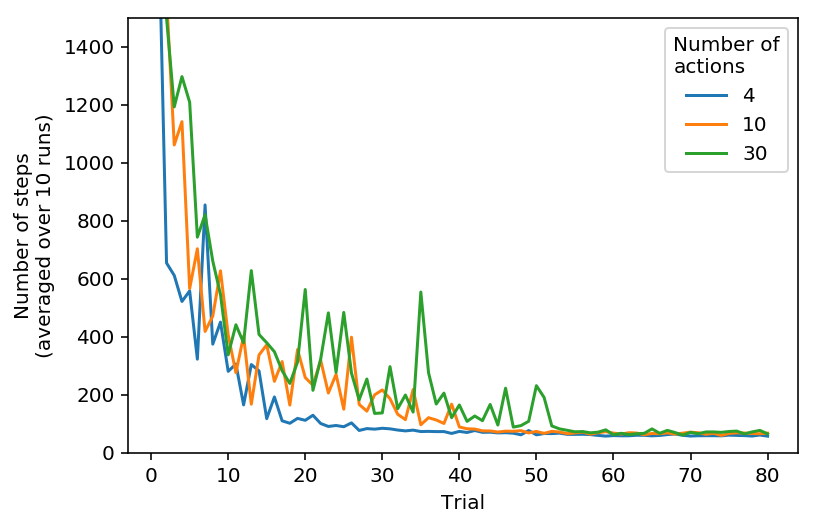

In [119]:
[plot_learning_curve(results[0], indicate_all=False) for results in results_per_num_actions]
plt.legend(num_actions_list, title='Number of\nactions')

- Higher number of actions learn a bit slower
- Higher number of actions take longer time to compute (bigger weight matrix)